In [1]:
%matplotlib notebook

import matplotlib as mpl
import DataSetQuery
import datetime
import pandas as pd
import MalardHelpers
import geopandas as gp
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
from rasterio.mask import mask
from shapely.geometry import Polygon, Point
from osgeo import gdal
import os
import numpy as np
from scipy.interpolate import griddata
import pandas as  pd
import geopandas as gp
from osgeo import gdal
import os
import json
import math
from pandas.io.json import json_normalize


In [2]:
environmentName = 'DEVv2'
query = DataSetQuery.DataSetQuery('http://localhost:9000',environmentName)

# 400000 500000 0 100000 mtngla testdataset HMA RGIv60 SDCv10 DebugRun
parentDsName = 'mtngla'
#dataset = 'tdxtest1'
dataset='tdx'
runName='DebugRun'
region = 'himalayas'

#Setup the bounding box
minX=400000
maxX=500000
minY=0
maxY=100000
bbx = query.getDataSetBoundingBox(parentDsName, dataset, region)
bbx = json.loads(bbx)
minT = datetime.datetime.utcfromtimestamp(bbx['minTime'])
maxT = datetime.datetime.utcfromtimestamp(bbx['maxTime'])

#The overall data cube for the two datasets
print(query.getDataSetBoundingBox(parentDsName,dataset, region))

{"gridCellMinX":-1900000,"gridCellMaxX":1700000,"gridCellMinY":-1300000,"gridCellMaxY":900000,"minTime":1279266673,"maxTime":1556381631,"totalPoints":5503342642,"numberOfShards":55681}


In [13]:
query.getDataSets('mtngla')

'[{"name":"publishtest","region":"himalayas"},{"name":"ADwithTDX","region":"alaska"},{"name":"srtm","region":"himalayas"},{"name":"tdx","region":"himalayas"}]'

In [6]:
print(query.getParentDataSets())
p = query.getProjection(parentDsName, region)
print(p)

[{"name":"cryotempo"},{"name":"mtngla"}]
{"shortName":"HMA","proj4":"+proj=aea +lat_1=25 +lat_2=47 +lat_0=36 +lon_0=85 +x_0=0 +y_0=0 +ellps=WGS84 +datum=WGS84 +units=m +no_defs"}


In [10]:
# @TODO change this
mGla = query.getGridCellMask(parentDsName, 'SDCv10', 'Debris', 'HMA',minX,minY,100000)
glacierMask = json.loads(mGla)['fileName']
glacierMask

'/data/puma1/scratch/malard/mask/mtngla/static/SDCv10/Debris/HMA/cell_x400000_y0_s100000/mask_Debris_x400000_y0_s100000.gpkg'

In [4]:

fp = query.executeQuery( parentDsName,dataset,region,minX,maxX,minY,maxY,minT,maxT,[],[])
df = MalardHelpers.getDataFrameFromNetCDF(fp)
fp

'/data/puma1/scratch/v2/malard/export/mtngla_tdx_859239744.nc'

In [65]:
df.columns

Index(['index', 'lon', 'lat', 'elev', 'heading', 'demDiff', 'demDiffMad',
       'demDiffMad2', 'phaseAmb', 'meanDiffSpread', 'wf_number', 'sampleNb',
       'power', 'powerdB', 'phase', 'phaseS', 'phaseSSegment',
       'phaseConfidence', 'coh', 'x', 'y', 'time', 'swathFileId', 'dataset',
       'debris', 'refElevation', 'refDifference'],
      dtype='object')

<IPython.core.display.Javascript object>


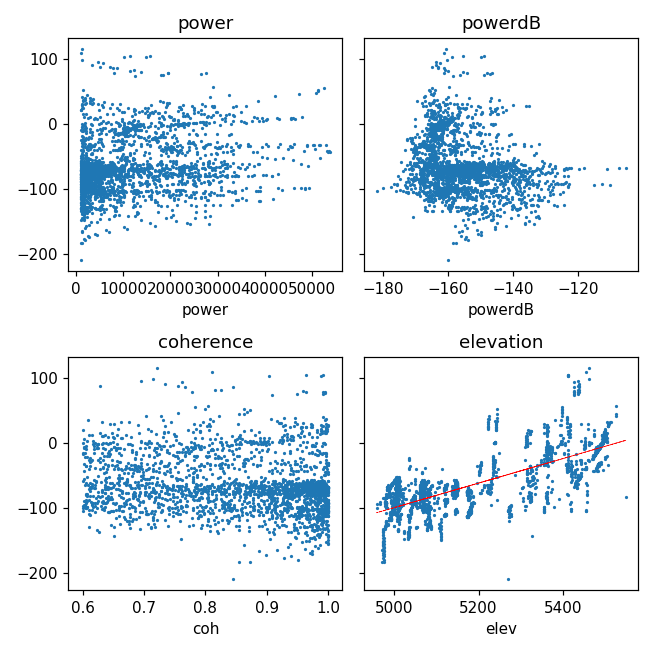

In [68]:
%matplotlib notebook
fig, axs = plt.subplots(2,2, figsize=(6,6), sharey=True)
# power
axs[0][0].scatter(x=df.power, y=df.refDifference, marker='.', s=5)
axs[0][0].set_xlabel('power')
axs[0][0].set_title('power')

axs[0][1].scatter(x=df.powerdB, y=df.refDifference, marker='.', s=5)
axs[0][1].set_xlabel('powerdB')
axs[0][1].set_title('powerdB')

axs[1][0].scatter(x=df.coh, y=df.refDifference, marker='.', s=5)
axs[1][0].set_xlabel('coh')
axs[1][0].set_title('coherence')

axs[1][1].scatter(x=df.elev, y=df.refDifference, marker='.', s=5)
axs[1][1].set_xlabel('elev')
axs[1][1].set_title('elevation')

z = np.polyfit(df.elev, df.refDifference, 1)
p = np.poly1d(z)
axs[1][1].plot(df.elev,p(df.elev),"r--", linewidth=0.5)

#plt.xlabel
#plt.colorbar()
#plt.title('Elevation difference to reference DEM against...')
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


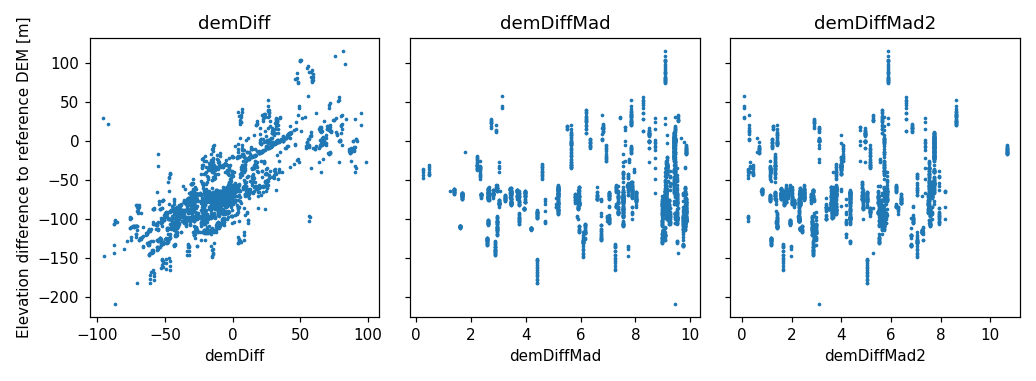

In [67]:
%matplotlib notebook
fig, axs = plt.subplots(1,3, figsize=(9.5,3.5), sharey=True)

axs[0].scatter(x=df.demDiff, y=df.refDifference, marker='.', s=8)
axs[0].set_xlabel('demDiff')
axs[0].set_title('demDiff')
axs[0].set_ylabel('Elevation difference to reference DEM [m]')

axs[1].scatter(x=df.demDiffMad, y=df.refDifference, marker='.', s=8)
axs[1].set_xlabel('demDiffMad')
axs[1].set_title('demDiffMad')

axs[2].scatter(x=df.demDiffMad2, y=df.refDifference, marker='.', s=8)
axs[2].set_xlabel('demDiffMad2')
axs[2].set_title('demDiffMad2')

plt.tight_layout()

plt.show()